In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

# Data wrangling and exploration

We begin by loading the two data sets and looking at the different attributes. We decide to add two columns **Movie release year** and **Actor birth year**.

In [3]:
# Load datasets
headers_character_metadata = ['Wikipedia Movie ID', 'Freebase Movie ID','Movie release date', 'Character name', 'Actor DOB', 
                              'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor name',
                              'Actor age at movie release', 'Freebase character map', 'Freebase character ID', 'Freebase actor ID']
character_metadata = pd.read_csv('./data/character.metadata.tsv', sep='\t', names=headers_character_metadata)

movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')

/var/folders/j2/9f4vw4v96p97ssvk4f1301sw0000gn/T/ipykernel_39935/2220621918.py:7: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  movie_metadata = pd.read_csv('./modified_data/movie_metadata_TMDB_FINAL.csv', sep=',')


In [4]:
# Rename 'Movie box office revenue enriched' to Movie box office revenue' for to match previous column name
movie_metadata = movie_metadata.rename(columns={'Movie box office revenue enriched': 'Movie box office revenue'})

In [5]:
# Add a column of release year to get consistency
character_metadata['Movie release year'] = character_metadata['Movie release date'].str.split('-').str[0].astype('float')
movie_metadata['Movie release year'] = movie_metadata['Movie release date'].str.split('-').str[0].astype('float')

# Add a column of birth year to get consistency
character_metadata['Actor birth year'] = character_metadata['Actor DOB'].str.split('-').str[0].astype('float')


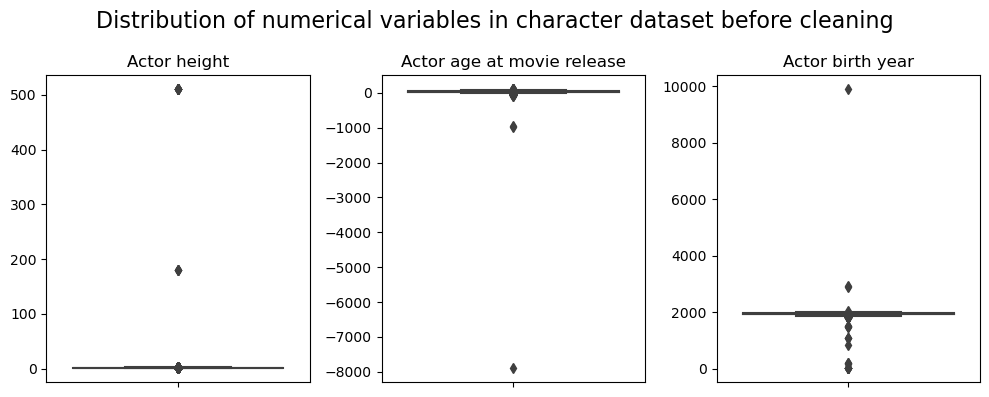

In [7]:
character_metadata_subset = character_metadata[['Actor height', 'Actor age at movie release', 'Actor birth year']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in character dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(character_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=character_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/before_cleaning_character')
plt.show()

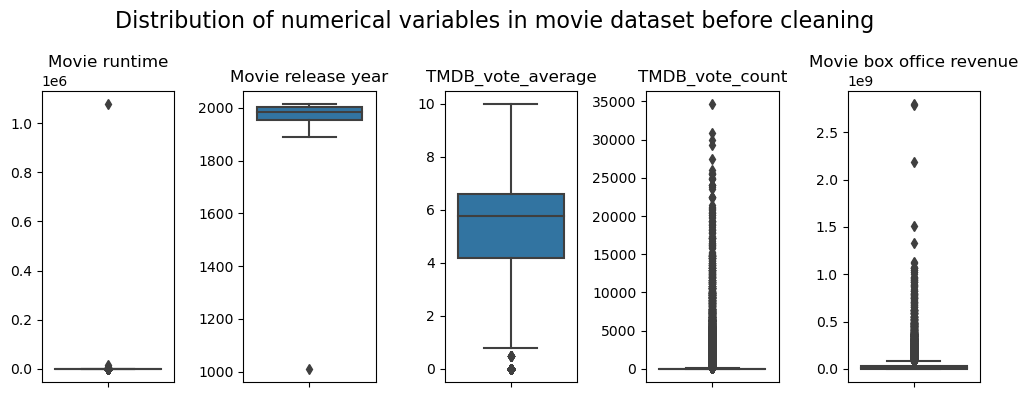

In [8]:
movie_metadata_subset = movie_metadata[['Movie runtime', 'Movie release year', 'TMDB_vote_average','TMDB_vote_count', 'Movie box office revenue']]

# Set up subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 4))
fig.suptitle('Distribution of numerical variables in movie dataset before cleaning', fontsize=16)

# Flatten the axes for easier indexing
axes = axes.flatten()

# Iterate through each column and create a boxplot in a subplot
for i, column in enumerate(movie_metadata_subset.columns):
    sns.boxplot(ax=axes[i], y=movie_metadata_subset[column])
    axes[i].set_title(f'{column}')
    axes[i].set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.savefig('figures/dist_and_clean/before_cleaning_movie')
plt.show()

## Remove outliers

### Character dataset

Now we look more closely at each attribute and remove unrealistic values. We first take a look at **Movie release year**:

In [10]:
# Define function that print the minimum and maximum values of a defines variable in the data frame
def get_min_and_max(df, variable_name, no_min, no_max):
    array = df[variable_name].fillna(0).unique()
    sorted_array = np.sort(array)
    
    min_values = sorted_array[:no_min]
    max_values = sorted_array[-no_max:]
    
    print(f"{no_min} minimum values of '{variable_name}':")
    print(min_values)
    print('\n')
    print(f"{no_max} maximum values of '{variable_name}':")
    print(max_values)


In [11]:
# Find all unique years as sort them
get_min_and_max(df=character_metadata, variable_name='Movie release year', no_min=5, no_max=5)

5 minimum values of 'Movie release year':
[   0. 1010. 1888. 1891. 1893.]


5 maximum values of 'Movie release year':
[2012. 2013. 2014. 2015. 2016.]


We remove values below year 1800.

In [12]:
condition1 = (character_metadata['Movie release year'] < 1800)
condition2 = (movie_metadata['Movie release year'] < 1800)

character_metadata.loc[condition1, 'Movie release year'] = np.nan
movie_metadata.loc[condition2, 'Movie release year'] = np.nan

We now take a look at **Actor birth year**:

In [13]:
get_min_and_max(df=character_metadata, variable_name='Actor birth year', no_min=15, no_max=5)

15 minimum values of 'Actor birth year':
[   0.   19.  183.  195.  852. 1075. 1474. 1498. 1796. 1804. 1828. 1829.
 1835. 1836. 1837.]


5 maximum values of 'Actor birth year':
[2011. 2050. 2896. 2936. 9900.]


We see, that some birth years are unrealistic and decide to remove birth years, that are below 1700 and above 2016 (last movie release year).

In [14]:
# Define the condition to identify rows where 'Actor birth year' needs to be set to NaN
condition = (character_metadata['Actor birth year'] < 1700) | (character_metadata['Actor birth year'] > 2016)
character_metadata.loc[condition, 'Actor birth year'] = np.nan

We now look at **Actor height**:

In [15]:
get_min_and_max(df=character_metadata, variable_name='Actor height', no_min=15, no_max=15)

15 minimum values of 'Actor height':
[0.      0.61    0.813   0.83    0.88    0.94    1.      1.06    1.067
 1.07    1.09728 1.1176  1.12    1.14    1.143  ]


15 maximum values of 'Actor height':
[  2.11      2.13      2.134     2.16      2.161     2.18      2.2
   2.24      2.28      2.29      2.31      2.31648   2.356   180.
 510.     ]


Again, we remove unrealistic values, which are people with a height more than 2.4 meter. The people with small heights are probably kids, but we leave these for now.

In [16]:
# Define the condition to identify rows where height needs to be set to NaN
condition = (character_metadata['Actor height'] > 2.4)
character_metadata.loc[condition, 'Actor height'] = np.nan

We now look at **Actor age at movie release**:

In [17]:
get_min_and_max(df=character_metadata, variable_name='Actor age at movie release', no_min=20, no_max=20)

20 minimum values of 'Actor age at movie release':
[-7896.  -969.  -937.   -81.   -76.   -65.   -63.   -57.   -53.   -51.
   -50.   -48.   -47.   -44.   -43.   -42.   -39.   -38.   -37.   -36.]


20 maximum values of 'Actor age at movie release':
[ 80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.
  94.  95.  96.  97.  99. 103.]


We remove ages, that are less than 0 and higher than 110.

In [18]:
# Define the condition to identify rows where age needs to be set to NaN
condition = (character_metadata['Actor age at movie release'] < 0) | (character_metadata['Actor age at movie release'] > 110)
character_metadata.loc[condition, 'Actor age at movie release'] = np.nan

### Movie dataset

Let's begin by looking at **Movie runtime**:


In [19]:
get_min_and_max(df=movie_metadata, variable_name='Movie runtime', no_min=15, no_max=15)

15 minimum values of 'Movie runtime':
[0.         0.03       0.05       0.08333333 0.1        0.11666667
 0.15       0.2        0.21666667 0.26666667 0.3        0.33333333
 0.36666667 0.4        0.41666667]


15 maximum values of 'Movie runtime':
[   1440.      1530.      1533.      1560.      1620.      1966.
    2425.      2880.      4875.27    5100.      5220.      5700.
    9360.     14400.   1079281.  ]


We decide to only look at movies that have a maximum runtime of 5 hours.

In [20]:
condition = (movie_metadata['Movie runtime'] > 5*60)
movie_metadata.loc[condition, 'Movie runtime'] = np.nan

Now let's take a look at **Movie box office revenue**:

In [21]:
get_min_and_max(df=movie_metadata, variable_name='Movie box office revenue', no_min=10, no_max=10)

10 minimum values of 'Movie box office revenue':
[ 0.  1.  3.  5.  6. 10. 12. 13. 14. 15.]


10 maximum values of 'Movie box office revenue':
[1.06317191e+09 1.06565981e+09 1.07800895e+09 1.11992952e+09
 1.12374700e+09 1.32811122e+09 1.51175791e+09 2.18537230e+09
 2.78227517e+09 2.80000000e+09]


As the box office revenue can have a huge span, and we don't have any negative values, we leave this for now.

## Missing values

Let's look at the amount of missing values in our data. For each attribute, the percentage of missing values is calculated.

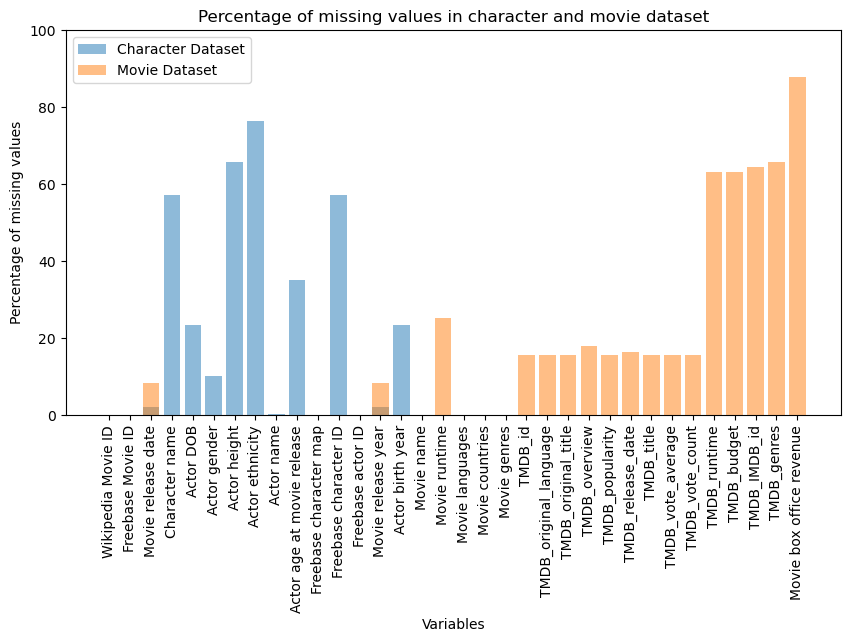

In [22]:
# Calculate percentage of missing values for each attribute
character_nan_percentages = character_metadata.isna().mean() * 100
movie_nan_percentages = movie_metadata.isna().mean() * 100

# Create a bar plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the character dataset NaN percentages
ax.bar(character_nan_percentages.index, character_nan_percentages, label='Character Dataset', alpha=0.5)

# Plot the movie dataset NaN percentages
ax.bar(movie_nan_percentages.index, movie_nan_percentages, label='Movie Dataset', alpha=0.5)

ax.set_ylim(0,100)
ax.set_xlabel('Variables')
ax.set_ylabel('Percentage of missing values')
ax.set_title('Percentage of missing values in character and movie dataset')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [23]:
movie_metadata['Movie box office revenue'].count()

10018

As we can see, there is a lot of missing values for some of the attributes. Especially **Movie box office revenue** has a lot of missing values (around 90%). We have already enriched the this attribute with more data, but it is still lacking, Despite the amount of missing values, we decide to work with it, since this attribute still has around 10'000 data points.

Some character attributes like height and ethnicity are also missing.

## Distribution of variables in the character dataset

We now want to look at the distribution of the attributes of the characters metadata set. We divide the character dataset into male and female character dataset, and use box plots and histograms to look at the distribution on the attributes. We also perform a t-test for each of the attributes with the nul-hypothesis: there is no difference between male and female.

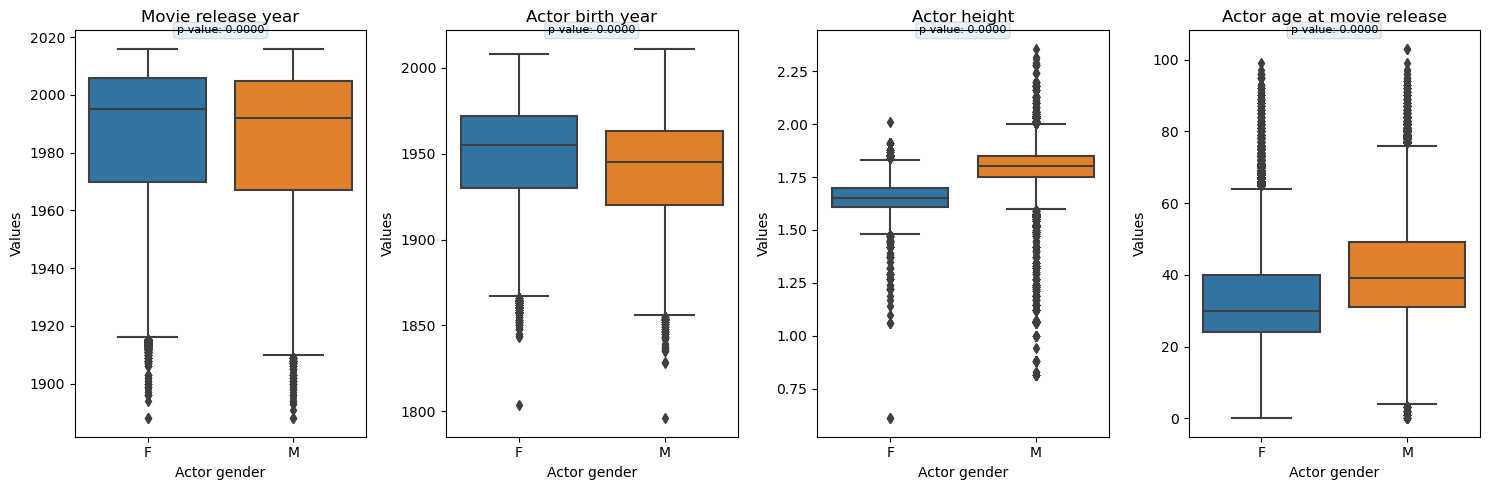

In [24]:
# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create a figure with four subplots
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create box plots for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Use sns.boxplot with 'Actor gender' as 'hue'
    sns.boxplot(x='Actor gender', y=variable, data=character_metadata, ax=ax)

    # Perform a t-test and get the p-value
    female_data = character_metadata[character_metadata['Actor gender'] == 'F'][variable].dropna()
    male_data = character_metadata[character_metadata['Actor gender'] == 'M'][variable].dropna()
    t_stat, p_value = stats.ttest_ind(female_data, male_data)

    # Annotate the plot with the p-value
    ax.annotate(f'p-value: {p_value:.4f}', xy=(0.5, max(ax.get_ylim())), ha='center', va='center',
                bbox=dict(boxstyle="round", alpha=0.1),
                fontsize=8, color='black')

    ax.set_ylabel('Values')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The first box plots show us, that more movies have been released in the more revent years. Naturally, the birth years of the actor are also more recent therefore. These also show us, that there is a significant difference in **Movie release year** and **Actor birth year** for male and female actors, where female actors are more represented in recent years. We might want to log-transform these attributes, if they are used in further analysis.

The height attribute shows that there is significant difference between the height of male and female, which makes sense, since men are naturally taller than woman.

The last box plot shows us, that there is a significant difference in the **Actor age at movie release** for male and female actors. It indicates, that female actors generally are younger than male actors in movies.

We also look at the distributions with a histogram:

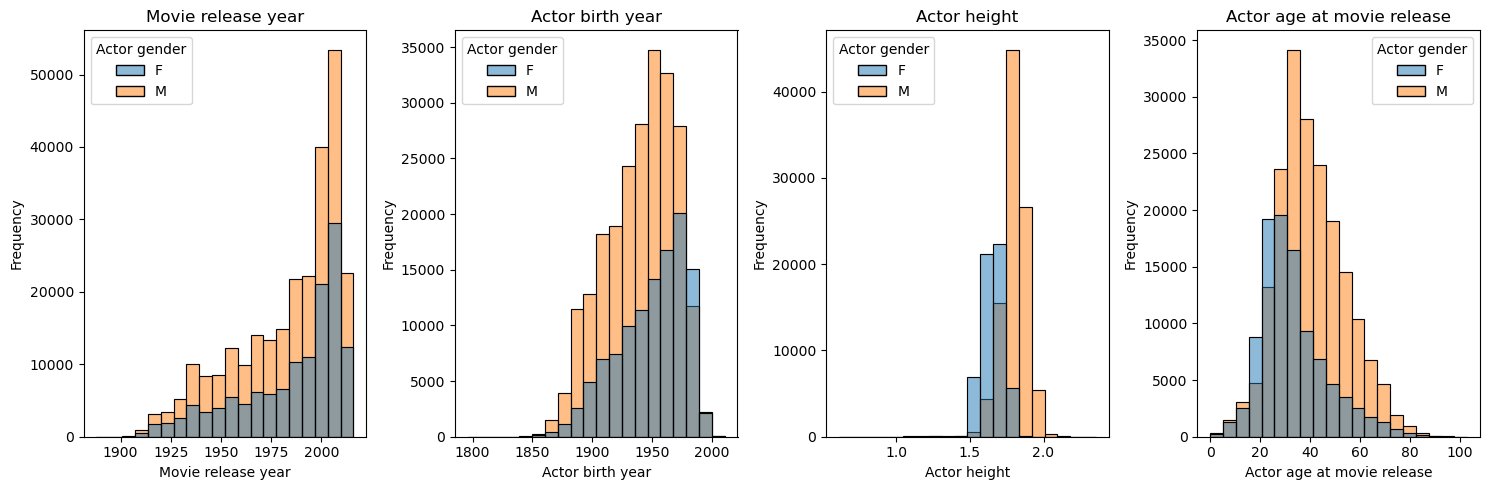

In [25]:
# Variables of interest
variables = ['Movie release year', 'Actor birth year', 'Actor height', 'Actor age at movie release']

# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=character_metadata, x=variable, bins=20, alpha=0.5, hue='Actor gender', multiple='layer', ax=ax)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()


The histogram backs up the claims made from the box plots.

We might want to

##  Distribution of variables in the movies dataset

In [26]:
numerical_variables = ['Movie box office revenue', 'Movie runtime', 'Movie release year']

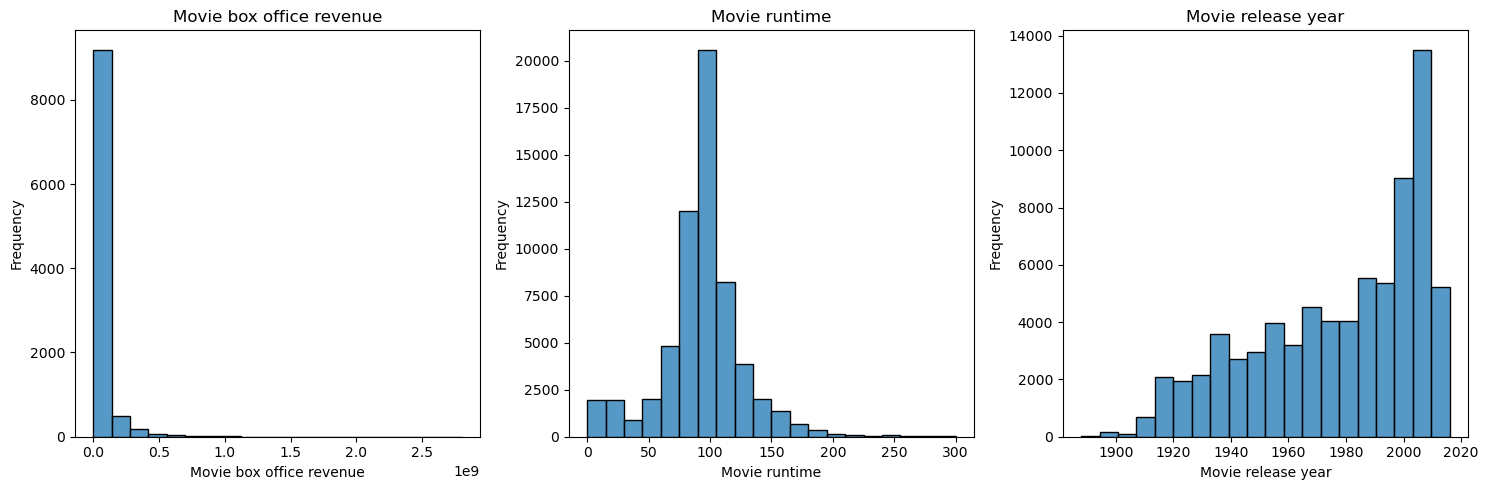

In [27]:
# Create a figure with four subplots (one for each variable)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(numerical_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title(variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

The plots show, that **Movie box office** has a highly right skewed distribution, also called a power law. We would need to transform this  attribute for further analysis.

The variable **Movie runtime* seem fairly normally distributed. The variable **Movie release year** is left skewed, so we will also try to apply a log transform to this.

In [28]:
movie_metadata['log Movie box office revenue'] = np.log(movie_metadata['Movie box office revenue'])

movie_metadata['log Movie release year'] = np.log(movie_metadata['Movie release year'])
character_metadata['log Movie release year'] = np.log(character_metadata['Movie release year'])

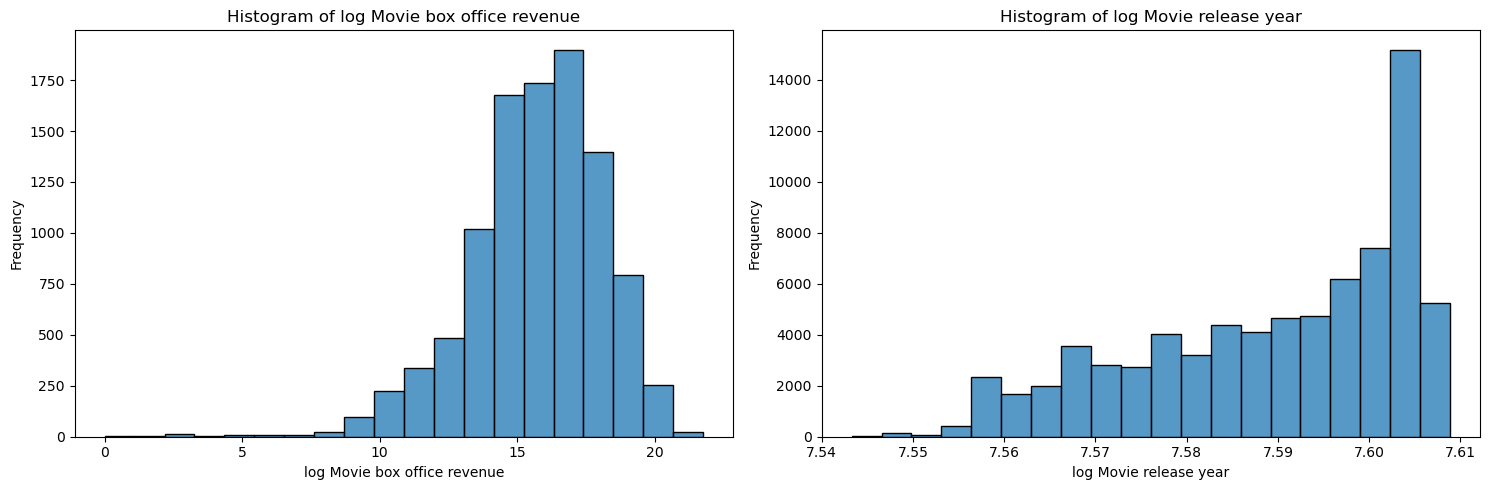

In [29]:
log_variables = ['log Movie box office revenue', 'log Movie release year']
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Create histograms for each variable in each subplot
for i, variable in enumerate(log_variables):
    ax = axes[i]

    # Create histograms for female and male characters for the current variable
    sns.histplot(data=movie_metadata, x=variable, ax=ax, bins=20)

    ax.set_xlabel(variable)
    ax.set_ylabel('Frequency')
    ax.set_title('Histogram of '+variable)

# Adjust the layout to prevent overlapping
plt.tight_layout()
plt.show()

After the log transform, **Movie box office revenue** is fairly normally distributed, but the log transform didn't do much for **Movie release year**, so we will keep this as it is.

### Categorical values

Let us take a look at the categorical values.

In [30]:
movie_metadata[['Movie genres', 'Movie languages', 'Movie countries']].head()

,Movie genres,Movie languages,Movie countries
0,"{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
1,"{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...","{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}"
2,"{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...","{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}"
3,"{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...","{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}"
4,"{""/m/07s9rl0"": ""Drama""}","{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}"


We convert all the values for consistency and check all unique values.

In [31]:
# Define categorical variables
categorical_variables = ['Movie genres', 'Movie languages', 'Movie countries']

# Transform categorical_variables to lists of strings
for variable in categorical_variables:
    cleaned_column_name = f"{variable}"
    movie_metadata[cleaned_column_name] = movie_metadata[variable].apply(lambda x: ", ".join(eval(x).values()) if isinstance(eval(x), dict) else "")
    
    # Remove 'Language' or ' language' from entries in the 'Movie languages' column
    if variable == 'Movie languages':
        movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].str.replace(' Language', '').str.replace(' language', '')
    
    # Convert the string representation to a list
    movie_metadata[cleaned_column_name] = movie_metadata[cleaned_column_name].apply(lambda x: x.split(', ') if x else [])


In [32]:
# Find unique original languages
unique_original_languages = movie_metadata['TMDB_original_language'].unique()
print(f"Number of original unique languages: {len(unique_original_languages)}")

display(unique_original_languages)

Number of original unique languages: 112


array(['en', 'no', 'de', 'es', 'ja', 'tr', nan, 'ru', 'it', 'hi', 'ml',
       'cn', 'fa', 'sv', 'pt', 'nl', 'pl', 'ko', 'hu', 'ta', 'fr', 'te',
       'sr', 'fi', 'zh', 'tl', 'da', 'ro', 'bn', 'cs', 'he', 'xx', 'sh',
       'id', 'mk', 'ar', 'bs', 'hr', 'el', 'yi', 'ku', 'sq', 'or', 'kn',
       'sk', 'lv', 'sl', 'et', 'th', 'pa', 'is', 'vi', 'km', 'ca', 'mr',
       'wo', 'bg', 'ur', 'ms', 'ky', 'cy', 'af', 'as', 'si', 'ka', 'mo',
       'ne', 'hy', 'st', 'bo', 'iu', 'lt', 'tg', 'kk', 'cv', 'mn', 'az',
       'rw', 'eu', 'uk', 'mg', 'bm', 'gu', 'ff', 'ht', 'ps', 'my', 'eo',
       'zu', 'ks', 'lb', 'ga', 'nb', 'fy', 'kl', 'gd', 'fo', 'am', 'mt',
       'ig', 'so', 'mi', 'la', 'uz', 'sw', 'tn', 'ay', 'sm', 'yo', 'be',
       'dz', 'jv'], dtype=object)

In [33]:
# Find unique movie languages

# Split the languages and create a new data frame with expanded rows
languages_df = movie_metadata['Movie languages'].explode().reset_index()

# Count the unique languages
unique_languages = languages_df['Movie languages'].unique()
print(f"Number of unique languages: {len(unique_languages)}")

display(unique_languages)

Number of unique languages: 211


array(['English', 'Norwegian', 'German', 'Silent film', 'Spanish',
       'Japanese', 'Turkish', nan, 'Russian', 'Italian', 'Tamil', 'Hindi',
       'Malayalam', 'Standard Mandarin', 'Afrikaans', 'Cantonese',
       'Standard Cantonese', 'Swedish', 'Danish', 'Portuguese', 'Dutch',
       'Polish', 'Korean', 'Hungary', 'Hungarian', 'Telugu', 'French',
       'Punjabi', 'Romani', 'Serbo-Croatian', 'Bulgarian', 'Serbian',
       'Arabic', 'Greek', 'Nepali', 'Swahili', 'Finnish', 'Tagalog',
       'Romanian', 'Bengali', 'Czech', 'Slovak', 'Chinese', 'Kannada',
       'Irish', 'Hebrew', 'Filipino', 'American English', 'Indonesian',
       'Gujarati', 'Urdu', 'Macedonian', 'Georgian', 'Croatian',
       'Bosnian', 'Albanian', 'Thai', 'Malay', 'Uzbek', 'Yiddish',
       'Brazilian Portuguese', 'Kurdish', 'Marathi', 'Persian',
       'Mandarin Chinese', 'Min Nan', 'Tibetans', 'Standard Tibetan',
       'Khmer', 'Ancient Greek', 'Oriya', 'Farsi', 'Western', 'Saami',
       'North', 'Samis', 'Am

Write cleaned data frames to csv files.

In [34]:
movie_metadata.to_csv('data_cleaned/movie_cleaned.csv')
character_metadata.to_csv('data_cleaned/character_cleaned.csv')